# Environment Perception For Self-Driving Cars

Welcome to the final assignment for this course. In this assignment, you will learn how to use the material so far to extract useful scene information to allow self-driving cars to safely and reliably traverse their environment.


**In this assignment, you will:**
- Use the output of semantic segmentation neural networks to implement drivable space estimation in 3D.
- Use the output of semantic segmentation neural networks to implement lane estimation.
- Use the output of semantic segmentation to filter errors in the output of 2D object detectors. 
- Use the filtered 2D object detection results to determine how far obstacles are from the self-driving car.

For most exercises, you are provided with a suggested outline. You are encouraged to diverge from the outline if you think there is a better, more efficient way to solve a problem.

Please go through cells in order. Lower cells will depend on higher cells to work properly.

You are only allowed to use the packages loaded bellow, mainly numpy, OpenCV, and the custom functions explained in the notebook. Run the cell bellow to import the required packages:

In [1]:
import numpy as np
import cv2
from numpy.linalg import inv, norm
from matplotlib import pyplot as plt
from m6bk import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(1)
np.set_printoptions(precision=2, threshold=np.inf)

## 0 - Loading and Visualizing the Data
We provide you with a convenient dataset handler class to read and iterate through samples taken from the CARLA simulator. Run the following code to create a dataset handler object. 

The dataset handler contains three test data frames 0, 1, and 2. Each frames contains:
- DatasetHandler().rgb: a camera RGB image 
- DatasetHandler().depth: a depth image containing the depth in meters for every pixel.
- DatasetHandler().segmentation: an image containing the output of a semantic segmentation neural network as the category per pixel. 
- DatasetHandler().object_detection: a numpy array containing the output of an object detection network. 

Frame 0 will be used throughout this note book as a running example. **Frame 1 will be used for submission and grading of this assesment.** Frame 2 is provided as a challange for learners interested in a more difficult example.

The current data frame being read can be known through the following line of code:

Text(0.5, 1.0, 'output of a semantic segmentation network')

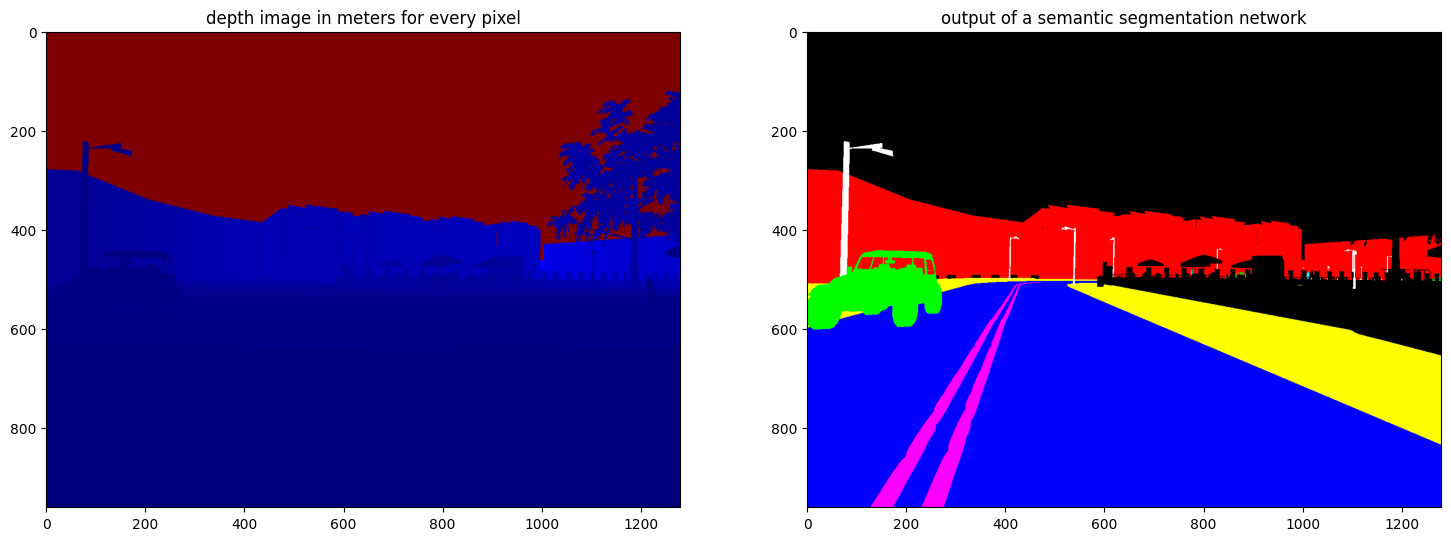

In [2]:
dataset_handler = DatasetHandler()
dataset_handler.set_frame(0)
dataset_handler.current_frame

f = dataset_handler.image
depth = dataset_handler.depth
segmentation = dataset_handler.segmentation
colored_segmentation = dataset_handler.vis_segmentation(segmentation)

_, ax = plt.subplots(1, 2, figsize=(18, 18)) 
ax[0].imshow(depth, cmap='jet')
ax[0].set_title("depth image in meters for every pixel")

# ax[1].imshow(segmentation)
ax[1].imshow(colored_segmentation)
ax[1].set_title("output of a semantic segmentation network")

 Upon creation of the dataset handler object, frame 0 will be automatically read and loaded. The frame contents can be accessed by using four different attributes of the dataset handler object: image, depth, object_detection, and semantic segmentation. As an example, to access the image, camera calibration matrix, and depth run the following three cells:    

In [3]:
image = dataset_handler.image
print(F"image.shape: {image.shape} \n")
print(F"depth.shape: {depth.shape} \n")
print(F"segmentation.shape: {segmentation.shape} \n")

image.shape: (960, 1280, 3) 

depth.shape: (960, 1280) 

segmentation.shape: (960, 1280) 



In [4]:
k = dataset_handler.k
print(k)

[[640   0 640]
 [  0 640 480]
 [  0   0   1]]


In [5]:
import ipywidgets as widgets
from IPython.display import display, clear_output

H, W = depth.shape
step = 8

# All patch coordinates
coords = [(i, j) for i in range(0, H, step)
                  for j in range(0, W, step)]

max_index = len(coords) - 1

out = widgets.Output()

# Widgets
index_input = widgets.BoundedIntText(
    value=0,
    min=0,
    max=max_index,
    description="Index:",
    layout=widgets.Layout(width="200px")
)

slider = widgets.IntSlider(
    value=0,
    min=0,
    max=max_index,
    step=1,
    description="",
    continuous_update=False
)

prev_button = widgets.Button(description="Previous")
next_button = widgets.Button(description="Next")

# Display function
def show_patch(idx):
    i, j = coords[idx]
    patch = depth[i:i+step, j:j+step]
    with out:
        clear_output(wait=True)
        print(f"Patch {idx}/{max_index}")
        print(f"Top-left corner: (i={i}, j={j})")
        print(patch)

# Sync widgets
def set_index(idx):
    index_input.value = idx
    slider.value = idx
    show_patch(idx)

def on_input_change(change):
    set_index(change["new"])

def on_slider_change(change):
    set_index(change["new"])

def on_prev_clicked(b):
    set_index(max(0, index_input.value - 10))

def on_next_clicked(b):
    set_index(min(max_index, index_input.value + 10))

index_input.observe(on_input_change, names="value")
slider.observe(on_slider_change, names="value")
prev_button.on_click(on_prev_clicked)
next_button.on_click(on_next_clicked)

controls = widgets.HBox([prev_button, next_button, index_input])
display(controls, slider, out)

# Initial display
show_patch(0)


IntSlider(value=0, continuous_update=False, max=19199)

Output()

The semantic segmentation output can be accessed in a similar manner through:

### Segmentation Category Mappings:
The output segmentation image contains mapping indices from every pixel to a road scene category. To visualize the semantic segmentation output, we map the mapping indices to different colors. The mapping indices and visualization colors for every road scene category can be found in the following table: 

|Category |Mapping Index| Visualization Color|
| --- | --- | --- |
| Background | 0 | Black |
| Buildings | 1 | Red |
| Pedestrians | 4 | Teal |
| Poles | 5 | White |
| Lane Markings | 6| Purple |
| Roads | 7 | Blue |
| Side Walks| 8 | Yellow |
| Vehicles| 10 | Green |

The vis_segmentation function of the dataset handler transforms the index image to a color image for visualization: 

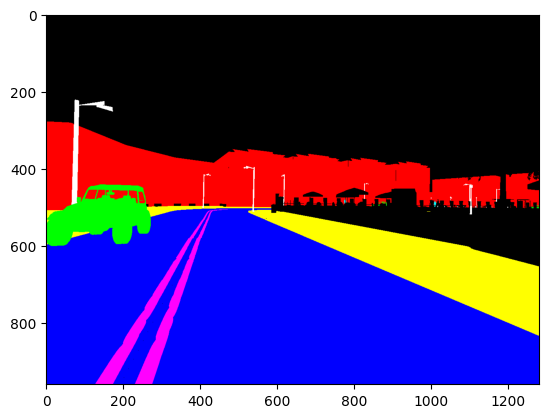

In [6]:
colored_segmentation = dataset_handler.vis_segmentation(segmentation)
plt.imshow(colored_segmentation)

The set_frame function takes as an input a frame number from 0 to 2 and loads that frame allong with all its associated data. It will be useful for testing and submission at the end of this assesment.

current frame: 1 



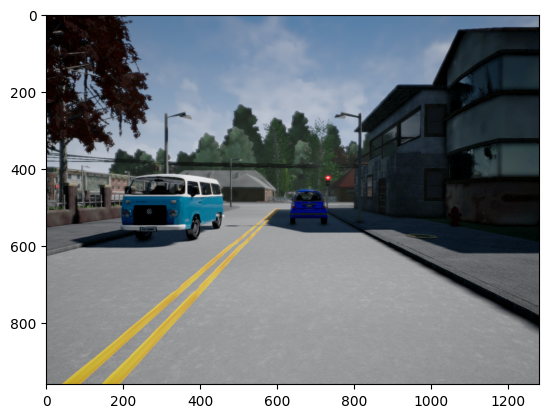

In [7]:
dataset_handler.set_frame(1)
fr = dataset_handler.current_frame
print(F"current frame: {fr} \n")

image = dataset_handler.image
plt.imshow(image)

## 1 - Drivable Space Estimation Using Semantic Segmentation Output

Your first task is to implement drivable space estimation in 3D. You are given the output of a semantic segmentation neural network, the camera calibration matrix K, as well as the depth per pixel.

### 1.1 - Estimating the x, y, and z coordinates of every pixel in the image:

You will be using the equations learned in module 1 to compute the x, y, and z coordinates of every pixel in the image. As a reminder, the equations to get the required 3D coordinates are:

$$z = depth $$

$$x = \frac{(u - u_c) * z}{f} \tag{1}$$

$$y = \frac{(v - v_c) * z}{f} \tag{2}$$

Here, $c_u$, $c_v$, and $f$ are the intrinsic calibration parameters found in the camera calibration matrix K such that:

$$K = \begin{pmatrix} f & 0 & u_c \\ 0 & f & v_c \\ 0& 0 & 1 \end{pmatrix}$$

***Note***: Make sure you are on frame 0 for the rest of this assessment. You will use the rest of the frames for testing after the assessment is done.

**Exercise**: Implement the estimation of the x and y coordinates of every pixel using equations (1) and (2):

In [8]:
# GRADED FUNCTION: xy_from_depth
def xy_from_depth(depth, K):
    """
    Computes the x, and y coordinates of every pixel in the image using the depth map and the calibration matrix.

    Arguments:
    depth -- tensor of dimension (H, W), contains a depth value (in meters) for every pixel in the image.
    k -- tensor of dimension (3x3), the intrinsic camera matrix

    Returns:
    x -- tensor of dimension (H, W) containing the x coordinates of every pixel in the camera coordinate frame.
    y -- tensor of dimension (H, W) containing the y coordinates of every pixel in the camera coordinate frame.
    """
    # Get the shape of the depth tensor
    H, W = depth.shape
    uv = np.array([[np.array([u+1, v+1, 1]) for u in range(W)]  for v in range(H)])
    uvd = depth.reshape(H, W, 1) * uv

    # Reshape uvd to ensure proper broadcasting
    uvd_reshaped = uvd.reshape(-1, 3).T

    # Compute xyz using matrix multiplication
    xyz = inv(K) @ uvd_reshaped

    # Reshape xyz back to the original image dimensions
    xyz = xyz.T.reshape(H, W, 3)

    x = xyz[:, :, 0]
    y = xyz[:, :, 1]
    return x, y

In [9]:
dataset_handler.set_frame(0)

k = dataset_handler.k
print(k)
z = dataset_handler.depth

x,y = xy_from_depth(z, k)

print('x[800,800] = ' + str(x[800, 800]))
print('y[800,800] = ' + str(y[800, 800]))
print('z[800,800] = ' + str(z[800, 800]) + '\n')

print('x[500,500] = ' + str(x[500, 500]))
print('y[500,500] = ' + str(y[500, 500]))
print('z[500,500] = ' + str(z[500, 500]) + '\n')

[[640   0 640]
 [  0 640 480]
 [  0   0   1]]
x[800,800] = 0.720475
y[800,800] = 1.436475
z[800,800] = 2.864

x[500,500] = -9.574276562499996
y[500,500] = 1.4464734375000035
z[500,500] = 44.083



**Expected Output**:

$x[800,800] = 0.720$
<br />
$y[800,800] = 1.436$
<br />
$z[800,800] = 2.864$

$x[500,500] = -9.5742765625$
<br />
$y[500,500] = 1.4464734375$
<br />
$z[500,500] = 44.083$

### 1.2 - Estimating The Ground Plane Using RANSAC:

In the context of self-driving cars, drivable space includes any space that the car is physically capable of traversing in 3D. The task of estimating the drivable space is equivalent to estimating pixels belonging to the ground plane in the scene. For the next exercise, you will use RANSAC to estimate the ground plane in the 3D camera coordinate frame from the x,y, and z coordinates estimated above. 

The first step is to process the semantic segmentation output to extract the relevant pixels belonging to the class you want consider as ground. For this assessment, that class is the road class with a mapping index of 7. To extract the x,y,z coordinates of the road, run the following cell:

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

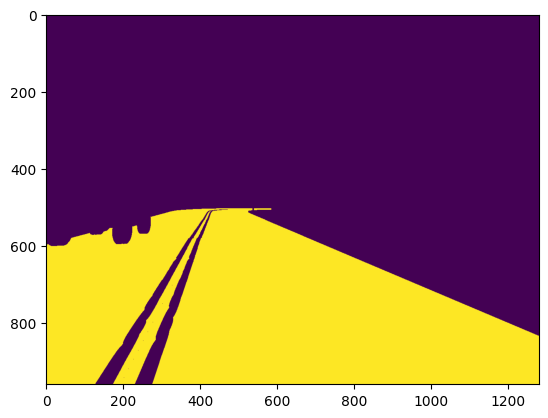

In [10]:
# Get road mask by choosing pixels in segmentation output with value 7
road_mask = np.zeros(segmentation.shape)
road_mask[segmentation == 7] = 1

# Show road mask
plt.imshow(road_mask)
road_mask[801:801+5, 810:815]

In [11]:
# Get x,y, and z coordinates of pixels in road mask
x_ground = x[road_mask == 1]
print(x_ground.shape)

y_ground = y[road_mask == 1]
print(y_ground.shape)

z_ground = z[road_mask == 1]

xyz_ground = np.stack((x_ground, y_ground, z_ground))
xyz_ground = xyz_ground.T
xyz_ground.shape

(411193,)
(411193,)


(411193, 3)

The next step is to use the extracted x, y, and z coordinates of pixels belonging to the road to estimate the ground plane. RANSAC will be used for robustness against outliers.

**Exercise**: Implement RANSAC for plane estimation. Here are the 6 steps:
1. Choose a minimum of 3 points from xyz_ground at random.
2. Compute the ground plane model using the chosen random points, and the provided function compute_plane.
3. Compute the distance from the ground plane model to every point in xyz_ground, and compute the number of inliers based on a distance threshold.
4. Check if the current number of inliers is greater than all previous iterations and keep the inlier set with the largest number of points.  
5. Repeat until number of iterations $\geq$ a preset number of iterations, or number of inliers $\geq$ minimum number of inliers.
6. Recompute and return a plane model using all inliers in the final inlier set. 

Useful functions: `np.random.choice()`, `compute_plane()`, `dist_to_plane()`.


The two custom functions are provided to help you finish this part:

1. ***compute_plane(xyz):***
```
    Computes plane coefficients a,b,c,d of the plane in the form ax+by+cz+d = 0

    Arguments:
    xyz -- tensor of dimension (3, N), contains points needed to fit plane.
    k -- tensor of dimension (3x3), the intrinsic camera matrix

    Returns:
    p -- tensor of dimension (1, 4) containing the plane parameters a,b,c,d
```

2. ***dist_to_plane(plane, x, y, z):***

```
    Computes distance from N points to a plane in 3D, given the plane parameters and the x,y,z coordinate of points.

    Arguments:
    plane -- tensor of dimension (4,1), containing the plane parameters [a,b,c,d]
    x -- tensor of dimension (Nx1), containing the x coordinates of the points
    y -- tensor of dimension (Nx1), containing the y coordinates of the points
    z -- tensor of dimension (Nx1), containing the z coordinates of the points


    Returns:
    distance -- tensor of dimension (N, 1) containing the distance between points and the plane
```

The functions are already loaded through the import statement at the beginning of the notebook. You also could perform plane estimation yourself if you are up for a challenge!

In [12]:
# GRADED FUNCTION: ransac_plane_fit
def ransac_plane_fit(xyz_data, num_iterations=100, distance_threshold=1e-4):
    """
    Estimates the plane coefficients a, b, c, d of the plane in the form ax + by + cz + d = 0
    using RANSAC for outlier rejection.

    Arguments:
    xyz_data -- tensor of dimension (N, 3), contains the 3D points.
    num_iterations -- number of RANSAC iterations.
    distance_threshold -- distance threshold to determine inliers.
    min_inliers -- minimum number of inliers to stop early.

    Returns:
    p -- tensor of dimension (1, 4) containing the plane parameters a, b, c, d.
    """
    def distance(xyz_data, plane):
        distances = np.abs(np.dot(xyz_data, plane[:3]) + plane[3]) / norm(plane[:3])
        return distances
    
    N = xyz_data.shape[0]
    min_inliers=0.99 * N
    best_inliers = []
    best_plane = None

    for _ in range(num_iterations):
        # Step 1: Choose 3 random points
        random_indices = np.random.choice(N, 3, replace=False)
        random_points = xyz_data[random_indices]

        # Step 2: Compute the plane model
        plane = compute_plane(random_points)

        # Step 3: Compute distances to the plane
        distances = distance(xyz_data, plane)

        # Step 4: Find inliers
        inliers = xyz_data[distances < distance_threshold]

        # Step 5: Check if this is the best model so far
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_plane = plane

        # Early stopping condition
        if len(best_inliers) >= min_inliers:
            break

    return best_plane

In [13]:
p_final = ransac_plane_fit(xyz_ground)
print(f'Ground Plane: {p_final}')

Ground Plane: [ 0.14 -0.95  0.29  0.74]


**Expected Output**:

Ground Plane: [0.01791606 -0.99981332  0.00723433  1.40281479]

To verify that the estimated plane is correct, we can visualize the inlier set computed on the whole image. Use the cell bellow to compute and visualize the ground mask in 2D image space.

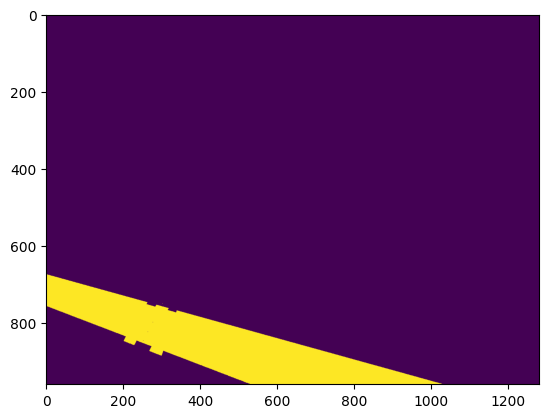

In [14]:
dist = np.abs(dist_to_plane(p_final, x, y, z))

ground_mask = np.zeros(dist.shape)

ground_mask[dist < 0.1] = 1
ground_mask[dist > 0.1] = 0

plt.imshow(ground_mask)

We also provide a function to visualize the estimated drivable space in 3D. Run the following cell to visualize your estimated drivable space in 3D.

/home/qd/controller2d-nix/course3/module6/m6bk.py:225: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/home/qd/controller2d-nix/course3/module6/m6bk.py:229: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


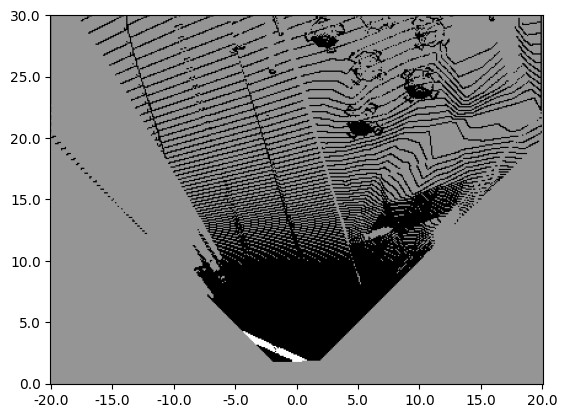

In [15]:
dataset_handler.plot_free_space(ground_mask)

The above visualization only shows where the self-driving car can physically travel. The obstacles such as the SUV to the left of the image, can be seen as dark pixels in our visualization: 

<tr>
<td> <img src="images/image.png" style="width:320px;height:240px;">   </td>
<td> <img src="images/occ_grid.png" style="width:240px;height:240px;">   </td>
</tr>

However, estimating the drivable space is not enough for the self-driving car to get on roads. The self-driving car still needs to perform lane estimation to know where it is legally allowed to drive. Once you are comfortable with the estimated drivable space, continue the assessment to estimate the lane where the car can drive.

## 2 - Lane Estimation Using The Semantic Segmentation Output

Your second task for this assessment is to use the output of semantic segmentation to estimate the lane boundaries of the current lane the self-driving car is using. This task can be separated to two subtasks, lane line estimation, and post-processing through horizontal line filtering and similar line merging.

### 2.1 Estimating Lane Boundary Proposals:
The first step to perform this task is to estimate any line that qualifies as a lane boundary using the output from semantic segmentation. We call these lines 'proposals'.

**Exercise**: Estimate lane line proposals using OpenCv functions. Here are the 3 steps:
1. Create an image containing the semantic segmentation pixels belonging to categories relevant to the lane boundaries, similar to what we have done previously for the road plane. For this assessment, these pixels have the value of 6 and 8 in the neural network segmentation output.
2. Perform edge detection on the derived lane boundary image.
3. Perform line estimation on the output of edge detection.

Useful functions: `cv2.Canny()`, `cv2.HoughLinesP()`, `np.squeeze()`.

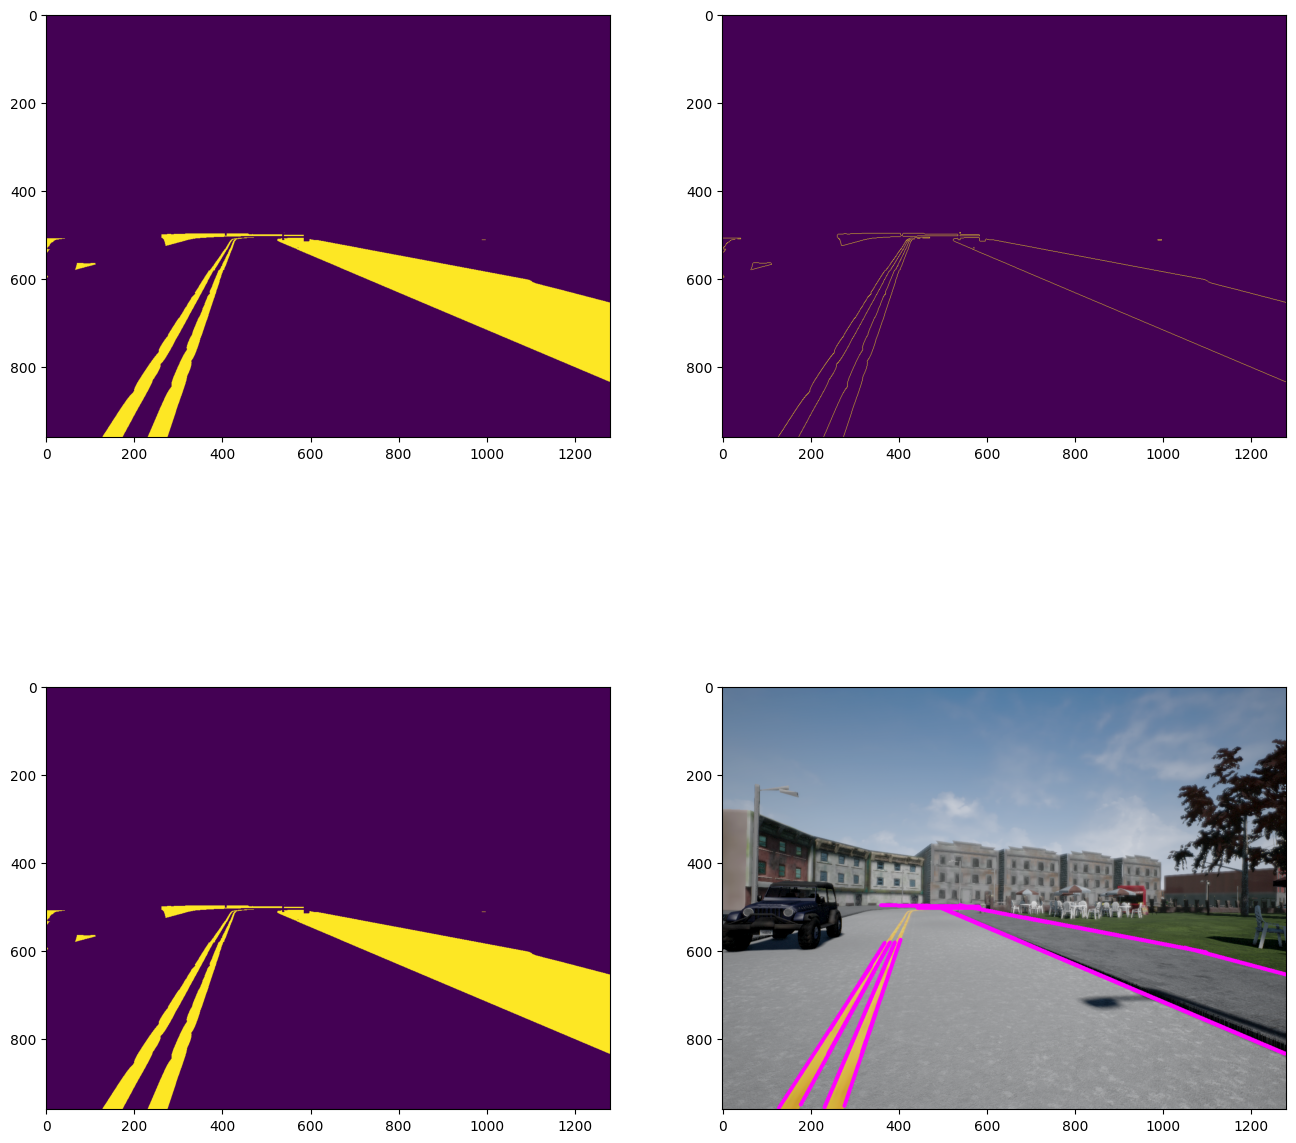

In [16]:
# GRADED FUNCTION: estimate_lane_lines
def estimate_lane_lines(segmentation_output, minLineLength=100, maxLineGap=45):
    """
    Estimates lines belonging to lane boundaries. Multiple lines could correspond to a single lane.

    Arguments:
    segmentation_output -- tensor of dimension (H,W), containing semantic segmentation neural network output
    minLineLength -- Scalar, the minimum line length
    maxLineGap -- Scalar, dimension (Nx1), containing the z coordinates of the points

    Returns:
    lines -- tensor of dimension (N, 4) containing lines in the form of [x_1, y_1, x_2, y_2], where [x_1,y_1] and [x_2,y_2] are
    the coordinates of two points on the line in the (u,v) image coordinate frame.
    """
    ### START CODE HERE ### (≈ 7 lines in total)
    # Step 1: Create an image with pixels belonging to lane boundary categories from the output of semantic segmentation
    lane_mask = np.zeros_like(segmentation_output)
    lane_mask[(segmentation_output == 6) | (segmentation_output == 8)] = 255
    lane_mask = lane_mask.astype(np.uint8)

    # Step 2: Perform Edge Detection using cv2.Canny()
    edges = cv2.Canny(lane_mask, 100, 200)

    # Step 3: Perform Line estimation using cv2.HoughLinesP()
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=100, 
                            minLineLength=minLineLength, maxLineGap=maxLineGap)
    
    # Note: Make sure dimensions of returned lines is (N x 4)
    if lines is not None:
        lines = np.squeeze(lines)
        if lines.ndim == 1:
            lines = lines.reshape(1, -1)
    ### END CODE HERE ###

    return lane_mask, edges, lines

lane_mask, edges, lines = estimate_lane_lines(segmentation)
_, ax = plt.subplots(2, 2, figsize=(16, 16), dpi=100)
ax[0, 0].imshow(lane_mask)
ax[0, 1].imshow(edges)
ax[1, 0].imshow(lane_mask)
ax[1, 1].imshow(dataset_handler.vis_lanes(lines))

***Expected Output***

<img src="images/lanes_1.png" style="width:320px;height:240px;"> 

### 2.2 - Merging and Filtering Lane Lines:

The second subtask to perform the estimation of the current lane boundary is to merge redundant lines, and filter out any horizontal lines apparent in the image. Merging redundant lines can be solved through grouping lines with similar slope and intercept. Horizontal lines can be filtered out through slope thresholding. 

**Exercise**: Post-process the output of the function ``estimate_lane_lines`` to merge similar lines, and filter out horizontal lines using the slope and the intercept. The three steps are:
1. Get every line's slope and intercept using the function provided.
2. Determine lines with slope less than horizontal slope threshold. Filtering can be performed later if needed.
3. Cluster lines based on slope and intercept as you learned in Module 6 of the course. 
4. Merge all lines in clusters using mean averaging.

Usefull Functions:
1. ***get_slope_intecept(lines):***

```
    Arguments:
    lines -- tensor of dimension (N,4) containing lines in the form of [x_1, y_1, x_2, y_2], the coordinates of two points on       the line

    Returns:
    slopes -- tensor of dimension (N, 1) containing the slopes of the lines
    intercepts -- tensor of dimension (N,1) containing the intercepts of the lines
```

This function is already loaded through the import statement at the beginning of the notebook. You also could perform plane estimation yourself if you are up for a challenge!

[[0, 2], [1, 8], [3, 6], [4], [5, 7, 9]]


array([[ 488.  ,  499.  , 1276.5 ,  833.5 ],
       [ 186.  ,  869.5 ,  353.5 ,  608.  ],
       [ 209.  ,  892.5 ,  363.  ,  614.  ],
       [ 232.  ,  956.  ,  392.  ,  581.  ],
       [ 303.67,  872.33,  379.33,  651.  ]])

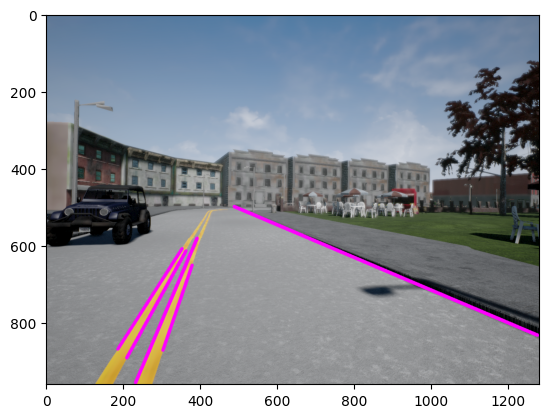

In [ ]:
# Graded Function: merge_lane_lines
def merge_lane_lines(lines, slope_similarity_threshold=0.1, intercept_similarity_threshold=40, min_slope_threshold=0.3):
    """
    Merges lane lines to output a single line per lane, using the slope and intercept as similarity measures.
    Also, filters horizontal lane lines based on a minimum slope threshold.

    Arguments:
    lines -- tensor of dimension (N, 4) containing lines in the form of [x1, y1, x2, y2],
    the coordinates of two points on the line.

    Returns:
    merged_lines -- tensor of dimension (N, 4) containing lines in the form of [x1, y1, x2, y2],
    the coordinates of two points on the line.
    """
    
    ### START CODE HERE ### (≈ 25 lines in total)
    
    # Step 0: Define thresholds in function parameters
    # Step 1: Get slope and intercept of lines
    slopes, intercepts = get_slope_intecept(lines)
    
    # Step 2: Filter out horizontal lines (lines with absolute slope less than threshold)
    non_horizontal_mask = np.abs(slopes) > min_slope_threshold
    filtered_lines = lines[non_horizontal_mask]
    filtered_slopes = slopes[non_horizontal_mask]
    filtered_intercepts = intercepts[non_horizontal_mask]
    
    if len(filtered_lines) == 0:
        return np.array([])
    
    # Step 3: Cluster lines based on slope and intercept similarity
    clusters = []
    used = np.zeros(len(filtered_lines), dtype=bool)
    
    for i in range(len(filtered_lines)):
        if used[i]:
            continue
        
        cluster = [i]
        used[i] = True
        
        for j in range(i + 1, len(filtered_lines)):
            if used[j]:
                continue
            
            # Check if slopes and intercepts are similar
            slope_diff = np.abs(filtered_slopes[i] - filtered_slopes[j])
            intercept_diff = np.abs(filtered_intercepts[i] - filtered_intercepts[j])
            
            if slope_diff <= slope_similarity_threshold and intercept_diff <= intercept_similarity_threshold:
                cluster.append(j)
                used[j] = True
        
        clusters.append(cluster)
    
    # Step 4: Merge lines in each cluster using mean averaging
    merged_lines = [np.mean(filtered_lines[c], axis=0) for c in clusters]    
    merged_lines = np.array(merged_lines)
    
    # Note: Make sure dimensions of returned lines is (N x 4)
    ### END CODE HERE ###
    return filtered_lines, merged_lines, clusters

filtered_lines, merged_lane_lines, clusters = merge_lane_lines(lines)
# plt.imshow(dataset_handler.vis_lanes(filtered_lines))
plt.imshow(dataset_handler.vis_lanes(merged_lane_lines))

print(clusters)
merged_lane_lines

***Expected Output***

<img src="images/lanes_2.png" style="width:320px;height:240px;"> 

You now should have one line per lane as an output! The final step is to extrapolate the lanes to start at the beginning of the road, and end at the end of the road, and to determine the lane markings belonging to the current lane. We provide you with functions that perform these tasks in the cell bellow. Run the cell to visualize the final lane boundaries!

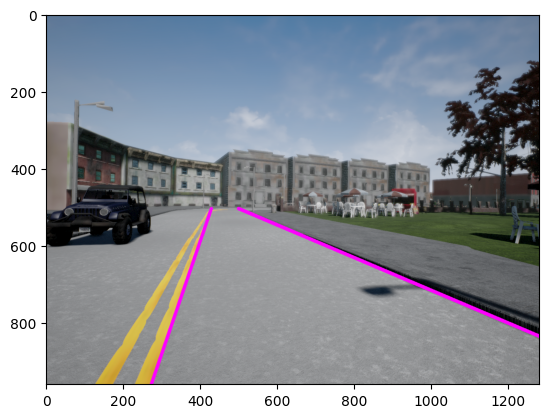

In [18]:
max_y = dataset_handler.image.shape[0]
min_y = np.min(np.argwhere(road_mask == 1)[:, 0])

extrapolated_lanes = extrapolate_lines(merged_lane_lines, max_y, min_y)
final_lanes = find_closest_lines(extrapolated_lanes, dataset_handler.lane_midpoint)
plt.imshow(dataset_handler.vis_lanes(final_lanes))

***Expected Output***

<img src="images/lanes_final.png" style="width:320px;height:240px;"> 

## 3 - Computing Minimum Distance To Impact Using The Output of 2D Object Detection.

Your final task for this assessment is to use 2D object detection output to determine the minimum distance to impact with objects in the scene. However, the task is complicated by the fact that the provided 2D detections are from a high recall, low precision 2D object detector. You will first be using the semantic segmentation output to determine which bounding boxes are valid. Then, you will compute the minimum distance to impact using the remaining bounding boxes and the depth image. Let us begin with a visualization of the output detection for our current frame. For visualization, you use the provided dataset handler function ``vis_object_detection`` as follows:

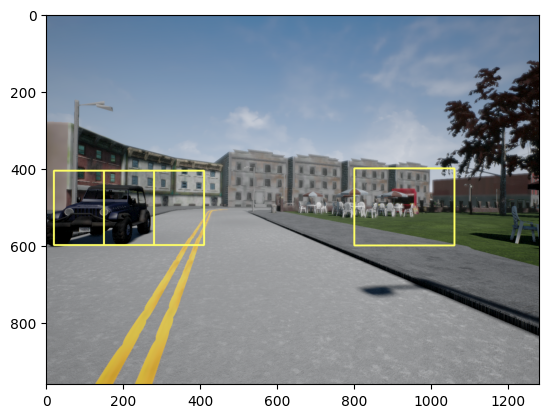

In [19]:
detections = dataset_handler.object_detection
plt.imshow(dataset_handler.vis_object_detection(detections))

Detections have the format [category, x_min, y_min, x_max, y_max, score]. The Category is a string signifying the classification of the bounding box such as 'Car', 'Pedestrian' or 'Cyclist'. [x_min,y_min] are the coordinates of the top left corner, and [x_max,y_max] are the coordinates of the bottom right corners of the objects. The score signifies the output of the softmax from the neural network.

In [20]:
print(detections)

[['Car' '20.0' '406.0' '280.0' '599.0' '0.99']
 ['Car' '150.0' '406.0' '410.0' '599.0' '0.95']
 ['Car' '800.0' '400.0' '1060.0' '600.0' '0.76']]


### 3.1 - Filtering Out Unreliable Detections:
The first thing you can notice is that an wrong detection occures on the right side of the image. What is interestingis that this wrong detection has a high output score of 0.76 for being a car. Furthermore, two bounding boxes are assigned to the vehicle to the left of the image, both with a very high score, greater than 0.9. This behaviour is expected from a high recall, low precision  object detector. To solve this problem, the output of the semantic segmentation network has to be used to eliminate unreliable detections.

**Exercise**: Eliminate unreliable detections using the output of semantic segmentation. The three steps are:
1. For each detection, compute how many pixels in the bounding box belong to the category predicted by the neural network.
2. Devide the computed number of pixels by the area of the bounding box (total number of pixels).
3. If the ratio is greater than a threshold keep the detection. Else, remove the detection from the list of detections.

Usefull functions: ``np.asfarray()``

***Note***: Make sure to handle both the 'Car' and 'Pedestrian' categories in the code.

In [21]:
#  Eliminate unreliable detections using the output of semantic segmentation. The three steps are:
# Set ratio threshold:
# ratio_threshold = 0.3  
# If 1/3 of the total pixels belong to the target category, the detection is correct.
# for detection in detections:  
    # Step 1: Compute number of pixels belonging to the category for every detection.
    # Step 2: Devide the computed number of pixels by the area of the bounding box (total number of pixels).
    # Step 3: If the ratio is greater than a threshold keep the detection. Else, remove the detection from the list of detections.
def filter_detections_by_segmentation(detections, segmentation_output, ratio_threshold=0.3):
    """
    Filter 2D detection output based on a semantic segmentation map.

    Arguments:
    detections -- tensor of dimension (N, 5) containing detections in the form of [Class, x_min, y_min, x_max, y_max, score].
    
    segmentation_output -- tensor of dimension (HxW) containing pixel category labels.
    
    Returns:
    filtered_detections -- tensor of dimension (N, 5) containing detections in the form of [Class, x_min, y_min, x_max, y_max, score].

    """
    ### START CODE HERE ### (≈ 20 lines in total)
    # Map detection categories to segmentation indices
    category_map = {
        'Car': 10,
        'Pedestrian': 4
    }
    
    filtered_detections = []
    
    for detection in detections:
        # Extract detection information
        category, x_min, y_min, x_max, y_max, _ = detection
        x_min, y_min, x_max, y_max = int(float(x_min)), int(float(y_min)), int(float(x_max)), int(float(y_max))
        
        # Get the corresponding segmentation category index
        if category not in category_map:
            continue
        
        seg_category = category_map[category]
        
        # Step 1: Compute number of pixels belonging to the category for every detection.
        bbox_segmentation = segmentation_output[y_min:y_max, x_min:x_max]
        matching_pixels = np.sum(bbox_segmentation == seg_category)
        
        # Step 2: Divide the computed number of pixels by the area of the bounding box (total number of pixels).
        total_pixels = (y_max - y_min) * (x_max - x_min)
        ratio = matching_pixels / total_pixels
        
        # Step 3: If the ratio is greater than a threshold keep the detection. Else, remove the detection from the list of detections.
        if ratio > ratio_threshold:
            filtered_detections.append(detection)
    
    filtered_detections = np.array(filtered_detections)
    
    ### END CODE HERE ###
    
    return filtered_detections

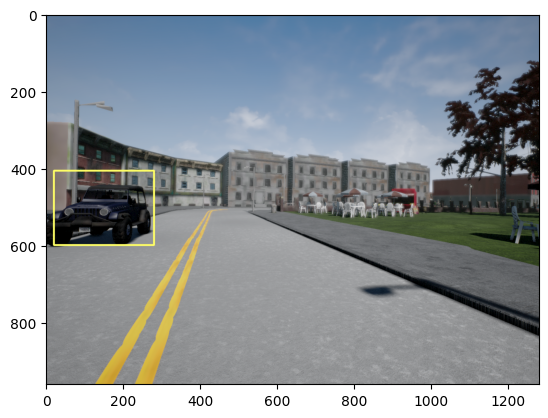

In [22]:
filtered_detections = filter_detections_by_segmentation(detections, segmentation)
plt.imshow(dataset_handler.vis_object_detection(filtered_detections))

### 3.2 - Estimating Minimum Distance To Impact:

The final task for this assessment is to estimate the minimum distance to every bounding box in the input detections. This can be performed by simply taking the minimum distance from the pixels in the bounding box to the camera center.

**Exercise**: Compute the minimum distance to impact between every object remaining after filtering and the self-driving car. The two steps are:

1. Compute the distance to the camera center using the x,y,z arrays from  part I. This can be done according to the equation: $ distance = \sqrt{x^2 + y^2 + z^2}$.
2. Find the value of the minimum distance of all pixels inside the bounding box.

In [23]:
# Compute the minimum distance to impact between every object in x, y, z tensors to center of camera (0, 0, 0) 
# 1. Compute the distance to the camera center using the x,y,z arrays. 
#       This can be done according to the equation: distance = sqrt{x^2 + y^2 + z^2}
# 2. Find the value of the minimum distance of all pixels inside the bounding box
def find_min_distance_to_detection(detections, x, y, z):
    """
    Compute the minimum distance to impact between every object in x, y, z tensors to center of camera.

    Arguments:
    detections -- tensor of dimension (N, 5) containing detections in the form of [Class, x_min, y_min, x_max, y_max, score].
    
    x -- tensor of dimension (H, W) containing the x coordinates of every pixel in the camera coordinate frame.
    y -- tensor of dimension (H, W) containing the y coordinates of every pixel in the camera coordinate frame.
    z -- tensor of dimensions (H,W) containing the z coordinates of every pixel in the camera coordinate frame.

    Returns:
    min_distances -- tensor of dimension (N, 1) containing distance to impact with every object in the scene.

    """
    ### START CODE HERE ### (≈ 20 lines in total)    
    min_distances = []
    for detection in detections:
        # Extract bounding box coordinates
        x_min, y_min, x_max, y_max = int(float(detection[1])), int(float(detection[2])), int(float(detection[3])), int(float(detection[4]))
        
        # Step 1: Compute distance of every pixel in the detection bounds
        x_bbox = x[y_min:y_max, x_min:x_max]
        y_bbox = y[y_min:y_max, x_min:x_max]
        z_bbox = z[y_min:y_max, x_min:x_max]
        
        # Compute Euclidean distance from camera center (0, 0, 0)
        distances = np.sqrt(x_bbox**2 + y_bbox**2 + z_bbox**2)
        
        # Step 2: Find minimum distance
        min_distance = np.min(distances)
        min_distances.append(min_distance)
    
    min_distances = np.array(min_distances)    
    return min_distances

In [24]:
min_distances = find_min_distance_to_detection(filtered_detections, x, y, z)
print('Minimum distance to impact is: ' + str(min_distances))


Minimum distance to impact is: [8.51]


**Expected Output**

Minimum distance to impact is: 8.51



Run the cell bellow to visualize your estimated distance along with the 2D detection output.

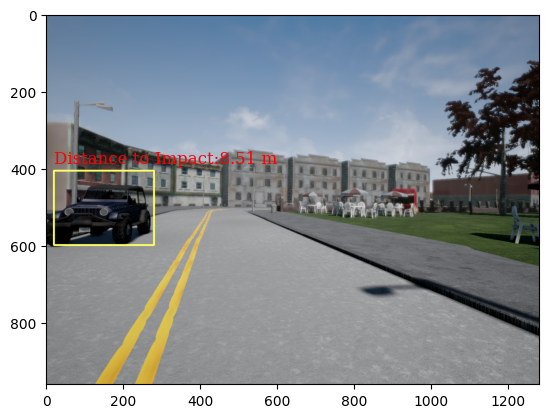

In [25]:
font = {'family': 'serif','color': 'red','weight': 'normal','size': 12}
im_out = dataset_handler.vis_object_detection(filtered_detections)

for detection, min_distance in zip(filtered_detections, min_distances):
    bounding_box = np.asarray(detection[1:5], dtype=float)
    plt.text(bounding_box[0], bounding_box[1] - 20, 'Distance to Impact:' + str(np.round(min_distance, 2)) + ' m', fontdict=font)

plt.imshow(im_out)

## 4 - Submission:

Evaluation of all the functions will be based on **three** outputs for frame 1 of the dataset:
1. The estimated ground plane from part 1.
2. The estimated lanes from part 2.
3. The estimated distances from part 3. 

Please run the cell bellow, then copy its output to the provided output.yaml file for submission on the programming assignment page.   

In [ ]:
dataset_handler = DatasetHandler()
dataset_handler.set_frame(1)
segmentation = dataset_handler.segmentation
detections = dataset_handler.object_detection
z = dataset_handler.depth

# Part 1
k = dataset_handler.k
x, y = xy_from_depth(z, k)
road_mask = np.zeros(segmentation.shape) # pyright: ignore[reportOptionalMemberAccess]
road_mask[segmentation == 7] = 1
x_ground = x[road_mask == 1]
y_ground = y[road_mask == 1]
z_ground = dataset_handler.depth[road_mask == 1] # pyright: ignore[reportOptionalSubscript]
xyz_ground = np.stack((x_ground, y_ground, z_ground))
p_final = ransac_plane_fit(xyz_ground.T)

# Part II
_, _, lane_lines = estimate_lane_lines(segmentation)
_, merged_lane_lines, _ = merge_lane_lines(lane_lines)

max_y = dataset_handler.image.shape[0] # pyright: ignore[reportOptionalMemberAccess]
min_y = np.min(np.argwhere(road_mask == 1)[:, 0])

extrapolated_lanes = extrapolate_lines(merged_lane_lines, max_y, min_y)
final_lanes = find_closest_lines(extrapolated_lanes, dataset_handler.lane_midpoint)

# Part III
filtered_detections = filter_detections_by_segmentation(detections, segmentation)
min_distances = find_min_distance_to_detection(filtered_detections, x, y, z)

# Print Submission Info

final_lane_printed = [np.round(lane).tolist() for lane in final_lanes]
print('plane:') 
if p_final is not None:
    print(np.round(p_final, 2).tolist())
else:
    print("Error: Ground plane estimation failed")
print('\n lanes:')
print(final_lane_printed)
print('\n min_distance:')
print(np.round(min_distances, 2).tolist())


plane:
[0.08, -1.0, 0.02, 1.2]

 lanes:
[[1566.0, 960.0, 670.0, 484.0], [190.0, 960.0, 619.0, 484.0]]

 min_distance
[7.01, 9.9]


### Visualize your Results:

Make sure your results visualization is appealing before submitting your results.

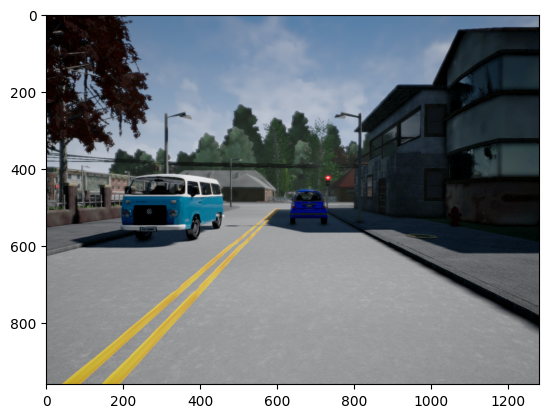

In [32]:
# Original Image
plt.imshow(dataset_handler.image)

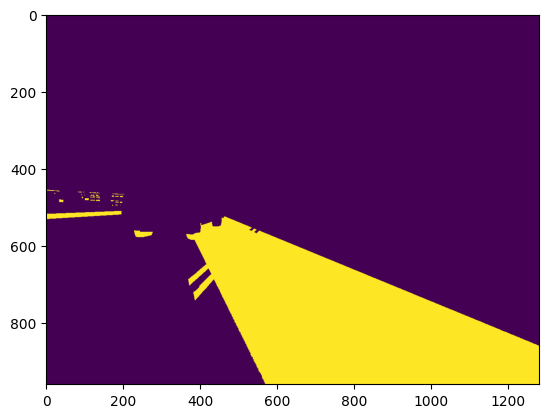

In [33]:
# Part I
dist = np.abs(dist_to_plane(p_final, x, y, z))

ground_mask = np.zeros(dist.shape)

ground_mask[dist < 0.1] = 1
ground_mask[dist > 0.1] = 0

plt.imshow(ground_mask)

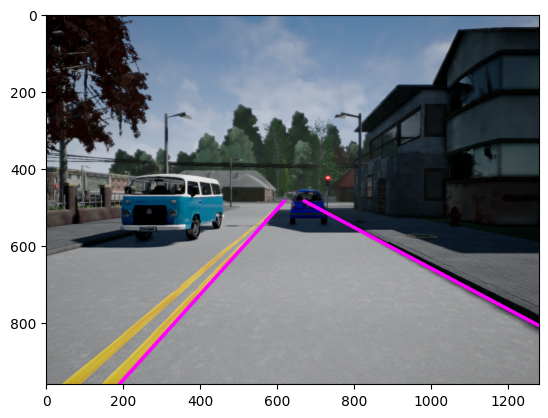

In [34]:
# Part II
plt.imshow(dataset_handler.vis_lanes(final_lanes))

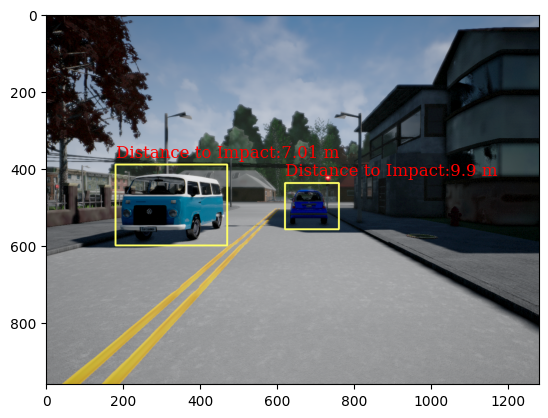

In [36]:
# Part III
font = {'family': 'serif','color': 'red','weight': 'normal','size': 12}

im_out = dataset_handler.vis_object_detection(filtered_detections)

for detection, min_distance in zip(filtered_detections, min_distances):
    bounding_box = np.asarray(detection[1:5], dtype=float)
    plt.text(bounding_box[0], bounding_box[1] - 20, 'Distance to Impact:' + str(np.round(min_distance, 2)) + ' m', fontdict=font)

plt.imshow(im_out)

<font color='blue'>
**What you should remember**:
- The output of semantic segmentation can be used to estimate drivable space. 
- Classical computer vision can be used to find lane boundaries.
- The output of semantic segmentation can be used to filter out unreliable output from object detection. 

Congrats on finishing this assignment! 